In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D plots
from numpy import random as rng

# Part 1

*Quantitatively evaluate the degree to which the purportedly random numbers generated by the internal numpy RNG are actually random by evaluating the full chi-squared distribution.*

We utilize the `my_uniform_chisq` function from the notebook, and define a function that returns the chi-squared value for a given number of samples and bins

In [2]:
# Simple function for computing a chi-squared given a set of input values from a histogram and their expectations
def my_uniform_chisq(bin_values, bin_expectations):
    num_bins = len(bin_values)
    chi_square = sum( ( ((bin_values[i] - bin_expectations[i])**2) / bin_expectations[i] ) for i in range(num_bins))
    return chi_square

In [3]:
# Return the chi-squared value for a given number of samples and bins
def chisq_single(samples, num_bins):
    data = rng.random(samples) 
    bin_values, bin_edges = np.histogram(data, num_bins)
    bin_expectations = [samples/num_bins] * num_bins
    chisq = my_uniform_chisq(bin_values,bin_expectations)
    
    return chisq

In [4]:
# Example: obtain chi-squared for given samples, num_bins
samples  = 1000
num_bins = 20
print(chisq_single(samples, num_bins))

13.200000000000001


In [5]:
# Repeat chi-squared evaluation over a large number of iterations
iterations = 2000
chisq_values = np.zeros(iterations)
for i in range(iterations):
    chisq_values[i] = chisq_single(samples, num_bins)

The [$\chi^2$ probability density function](https://en.wikipedia.org/wiki/Chi-squared_distribution#Probability_density_function) is

$f(x; k) = \dfrac{x^{k/2-1}e^{-x/2}}{2^{k/2}\Gamma(k/2)}$

where $\Gamma(k/2)$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function). You can either define this function yourself (using [`scipy.special.gamma`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.gamma.html) or Python's built in `math.gamma`), or utilize scipy's available [probability distribution functions](https://docs.scipy.org/doc/scipy-0.15.1/reference/stats.html), which has `scipy.stats.chi2`

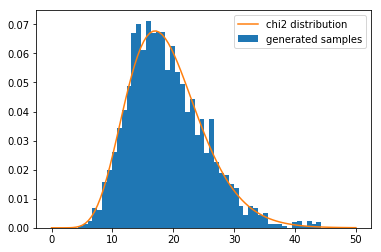

In [6]:
from scipy.stats import chi2

# set density=True so that a true PDF is generated
plt.hist(chisq_values, bins=50, density=True, label='generated samples')
rv = chi2(num_bins-1)
x = np.linspace(0, 50, 100)
plt.plot(x, rv.pdf(x), label='chi2 distribution')
plt.legend()

# Part 2

*Test at least 2 additional random number generators by either creating your own (e.g. linear congruential generators such as the IBM one discussed in class), or using other libraries in python (e.g. `rng = random.SystemRandom()`).*

We will compare the results of three methods: `numpy.random` (part 1), Python's `random`, and the IBM random method. To do this, it's helpful to put the code from part 1 into a single function where the random number generator is abstracted out

In [7]:
# Return the chi-squared value for a given number of samples and bins; now using a custom generator
def chisq_single(gen, samples, num_bins):
    data = gen(samples)    # gen(N) is any function that returns N samples
    bin_values, bin_edges = np.histogram(data, num_bins)
    bin_expectations = [samples/num_bins] * num_bins
    chisq = my_uniform_chisq(bin_values,bin_expectations)
    
    return chisq

# For a given generator, produce chi-squared values over a large number of iterations
def sample_chisq(gen, iterations=10000):
    chisq_values = np.zeros(iterations)
    for i in range(iterations):
        chisq_values[i] = chisq_single(gen, samples, num_bins)
    
    return chisq_values

# Plot a hisogram of chi-squared values along with the analytic curve
def plot_chisq_values(values):
    count, edges, patches = plt.hist(values, bins=50, density=True, label='generated samples')
    rv = chi2(num_bins-1)
    x = np.linspace(edges[0], edges[-1], 100)
    plt.plot(x, rv.pdf(x), label='chi2 distribution')
    plt.legend()

The previous solution is obtained by now doing:

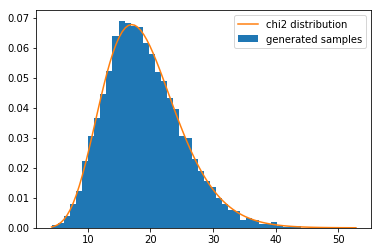

In [8]:
gen = np.random.random
values = sample_chisq(gen)
plot_chisq_values(values)

For Python's random module, `random` does not take any arguments like `numpy.random` does, so we have to define the `gen` function to iterate over N samples

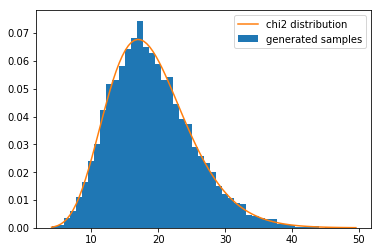

In [9]:
from random import random
gen = lambda N: [random() for n in range(N)]   # Python's lambda is short-hand for defining functions
values = sample_chisq(gen)
plot_chisq_values(values)

For IBM's random method, we have a starting seed value and the next pseudo-random value is obtained using the recursion relation

$ x_{i+1} = (a x_i + c) \mod m $

with $a = 65539$, $c = 0$, and $m = 2^{31}$

This generates a 'random' number between 1 and $2^{31} - 1$ (the largest value of a 32-bit signed integer before overflowing). To map the value between 0 and 1, $x$ is simply divided by $m-1$

In [10]:
def ibm_random(seed=1):
    a = 65539
    c = 0
    m = 2**31
    
    x = seed
    while True:
        yield x/(m-1)   # yield: return this value, but continue the function from this location on the next call, keeping the previous value of x stored
        x = (a*(x + c)) % m

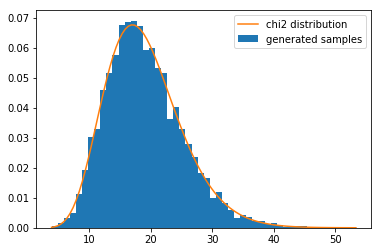

In [11]:
random_iter = ibm_random()   # create an instance of the ibm_random recurrence
gen = lambda N: [next(random_iter) for n in range(N)]   # calling next(...) evaluates random_iter until the next yield occurs 
values = sample_chisq(gen)
plot_chisq_values(values)

# Part 3

*Evaluate the effect of using different seeds*

Let's first confirm that two sets of randomly generated numbers with the same seeds are identical

In [12]:
np.random.seed(0)
print(np.random.random(5))

# repeat the same thing
np.random.seed(0)
print(np.random.random(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]
[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ]


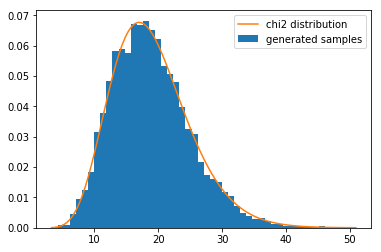

In [13]:
np.random.seed(0)
gen = np.random.random
values = sample_chisq(gen)
plot_chisq_values(values)

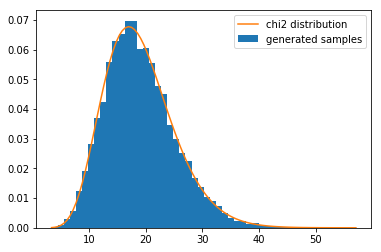

In [14]:
# Try different seeds
np.random.seed(5000)
gen = np.random.random
values = sample_chisq(gen)
plot_chisq_values(values)

# Part 4

*Much like our `sum` example above, try to evaluate the correlation between two and three different random numbers. A suggestion for doing this is to create 2D and 3D graphs and evaluate the correlations that way. You are expected to try this, especially if you already know some programming.*

If we judged the quality of a random number generator solely on the chi-squared tests performed in part 2, we would likely conclude that the three methods were all equally good. However, we have not considered possible correlations between 1 generated number and the next. For any good RNG, each random number should be uncorrelated from the numbers that were generated before it. 

To look at correlations between one random number and the next, we can plot $(x_{2i}, x_{2i+1})$ pairs in two dimensions or $(x_{3i}, x_{3i+1}, x_{3i+2})$ in three dimensions. If the numbers are uncorrelated, these points should fill the space uniformly. Starting with 30,000 random samples using `numpy.random`

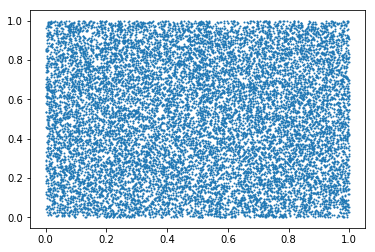

In [15]:
x = np.random.random(30000)
plt.scatter(x[::2], x[1::2], s=1)   # array slice [1::2] means start at 1 and select every 2 elements until the end

To quantify the uniformity of this distribtution, we can bin them into 2D voxels and compute chi-squared values just as we did before in 1D.

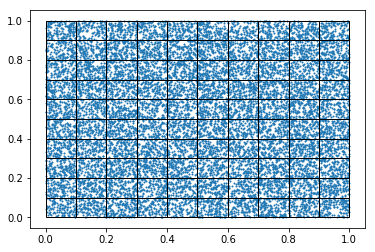

In [16]:
# histogram2d bins 2D data
bins = 10
hist, xedges, yedges = np.histogram2d(x[::2], x[1::2], bins=bins)

# plot the 2D voxels on top of the data
plt.scatter(x[::2], x[1::2], s=1)
for xe in xedges[:-1]:
    for ye in yedges[:-1]:
        box = plt.Rectangle((xe,ye), width=1/bins, height=1/bins, facecolor='None', edgecolor='k')
        plt.gca().add_patch(box)

We can then plot a 3D bar plot showing the total count in each voxel

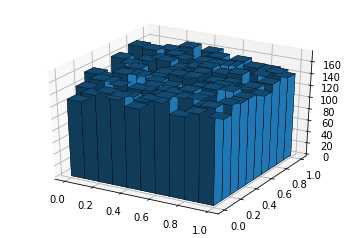

In [17]:
# x, y, z positions of the bars (as flat arrarys)
xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1])
xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros_like(xpos)

# widths and heights of the bars
dx = (xedges[1] - xedges[0])
dy = dx
dz = hist.flatten()

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, edgecolor='k', lw=.3)

The chi-squared analysis can be repeated in 2D with small modifications

In [18]:
# Return the chi-squared value for a given number of samples and bins with a custom generator; now in 2D
def chisq_single_2d(gen, samples, num_bins):
    data = gen(2*samples)    # generate twice the number of random points for N pair samples
    bin_values, xedges, yedges = np.histogram2d(data[::2], data[1::2], num_bins)
    bin_expectations = [samples/num_bins**2] * num_bins**2   # num_bins^2 is the total number of bins
    chisq = my_uniform_chisq(bin_values.flatten(), bin_expectations)    # flatten the bin_values to 1d array
    
    return chisq

# For a given generator, produce chi-squared values over a large number of iterations
def sample_chisq_2d(gen, iterations=4000):
    chisq_values = np.zeros(iterations)
    for i in range(iterations):
        chisq_values[i] = chisq_single_2d(gen, samples, num_bins)
    
    return chisq_values

# Plot a hisogram of chi-squared values along with the analytic curve
def plot_chisq_values_2d(values):
    count, edges, patches = plt.hist(values, bins=50, density=True, label='generated samples')
    rv = chi2(num_bins**2-1)        # k-value is now bins^2 - 1
    x = np.linspace(edges[0], edges[-1], 100)
    plt.plot(x, rv.pdf(x), label='chi2 distribution')
    plt.legend()

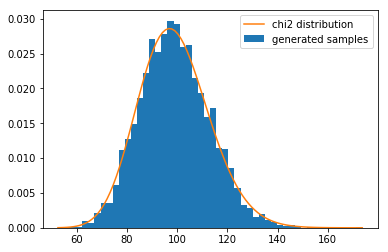

In [19]:
num_bins = 10
samples = 10000
gen = np.random.random
values = sample_chisq_2d(gen)
plot_chisq_values_2d(values)

We apply the same technique to the 3D case, except this time we use every third element in the array

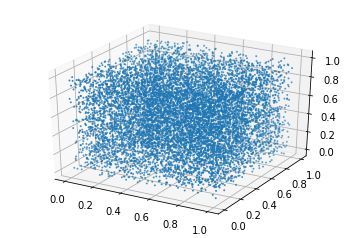

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::3], x[1::3], x[2::3], s=1)  # plot every third element on each axis

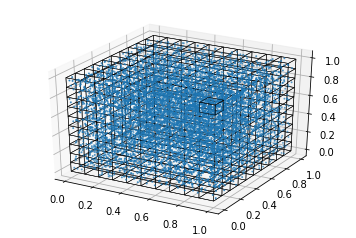

In [21]:
# uncomment this to view plots interactively in a separate window
#%matplotlib qt

# histogramdd will bin data of any dimensionality (3D in this case)
hist, (xedges, yedges, zedges) = np.histogramdd([x[::3],x[1::3],x[2::3]], bins=bins)

# 3D voxels visualized on top of data
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(x[::3], x[1::3], x[2::3], s=1)

voxels = np.ones((bins,bins,bins), dtype=bool)
X, Y, Z = np.meshgrid(xedges, yedges, zedges)
ax.voxels(X, Y, Z, voxels, facecolors=(0,0,0,0), edgecolor='k', lw=0.5);

We cannot visualize a 4D bar plot in this case, but the chi-squared analysis can still be done

In [22]:
# Return the chi-squared value for a given number of samples and bins with a custom generator; now in 3D
def chisq_single_3d(gen, samples, num_bins):
    data = gen(3*samples)    # generate thrice the number of random points for N triplet samples
    bin_values, (xedges, yedges, zedges) = np.histogramdd([data[::3], data[1::3], data[2::3]], num_bins)
    bin_expectations = [samples/num_bins**3] * num_bins**3   # num_bins^3 is the total number of bins
    chisq = my_uniform_chisq(bin_values.flatten(), bin_expectations)    # flatten the bin_values to 1d array
    
    return chisq

# For a given generator, produce chi-squared values over a large number of iterations
def sample_chisq_3d(gen, iterations=4000):
    chisq_values = np.zeros(iterations)
    for i in range(iterations):
        chisq_values[i] = chisq_single_3d(gen, samples, num_bins)
    
    return chisq_values

# Plot a hisogram of chi-squared values along with the analytic curve
def plot_chisq_values_3d(values):
    count, edges, patches = plt.hist(values, bins=50, density=True, label='generated samples')
    rv = chi2(num_bins**3-1)        # k-value is now bins^3 - 1
    x = np.linspace(edges[0], edges[-1], 100)
    plt.plot(x, rv.pdf(x), label='chi2 distribution')
    plt.legend()

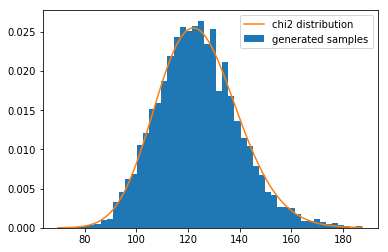

In [23]:
num_bins = 5
samples = 30000
gen = np.random.random
values = sample_chisq_3d(gen)
plot_chisq_values_3d(values)

For IBM's random generator:

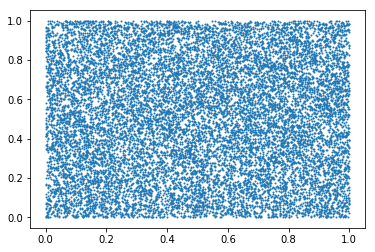

In [24]:
random_iter = ibm_random()
x = [next(random_iter) for n in range(30000)] 
plt.scatter(x[::2], x[1::2], s=1)

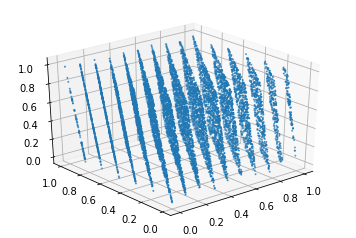

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[::3], x[1::3], x[2::3], s=1)
ax.view_init(30, 230)   # change the view angles

The IBM random generator fails the test in 3D where the points clearly do not fill the space uniformly. This is due to the undesired recursion relationship $x_{k+2} = 6x_{k+1} - 9x_k$. We can numerically confirm this recursion relationship for our data:

In [26]:
i = 5
print(x[i+2], 6*x[i+1] - 9*x[i])

0.1557322196456288 0.1557322196456288


The chi-squared test will fail in this case

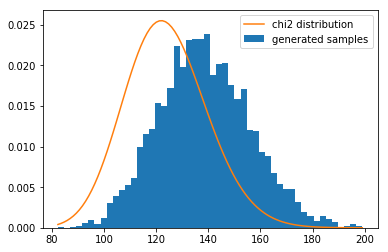

In [27]:
num_bins = 5
samples = 30000

random_iter = ibm_random()
gen = lambda N: [next(random_iter) for n in range(N)]

values = sample_chisq_3d(gen)
plot_chisq_values_3d(values)